# DSGE Exercise 8

** Question 8:**

For the Brock and Mirman model set up a discrete grid for $K$ with 26 values ranging from $.5 \bar K$ to $1.5 \bar K$.  Also set up a discrete grid for $z$ with 26 values ranging from $-5\sigma$ to $+5\sigma$.  Set up a value function array, $V$ that stores the value for all $26^2$ possible permutations of $K$ and $z$.  Also set up a policy function array, $H$, that stores the optimal index value of $K'$ for all all $26^2$ possible permutations of $K$ and $z$.

To begin assume that all elements of $V$ are zero and that all elements of $H$ point to the lowest possible value for $K$ ($.5 \bar K$).

Loop over all possible values of $K$ and $z$ and for each combination find 1) the optimal value of $K'$ from the 26 possible values.  Store this value in an updated policy function array, $H_{new}$.  Also find 2) the value implied by this choice given the current value function.  Store this in an updated value function array, $V_{new}$.

Once this is completed for all $K$ and $z$ check to see if $V$ is approximately equal to $V_{new}$.  If so, output the value function and policy function arrays.  If not, replace $V$ with $V_{new}$ and $H$ with $H_{new}$ and repeat the search above.

When finished plot the three-dimensional surface plot for the policy function $K' = H(K,z)$.  Compare this with the closed form solution.


Let's use a Python program to find the steady state values given the closed-form solution above.  We will define a function that returns the steady state values of the non-state variables as a function of the steady state value for $k$.

** Answer: **

First, write a function that returns values for non-state variables, given known state variables.

In [1]:
def modeldefs(k, kp, z, *mparams):
    # This function takes the following inputs:
    #  k - capital stock today
    #  kp - capital stock next period
    #  z - productivity today
    # It returns the following:
    #  y - output
    #  r - rental rate on capital
    #  w - wage rate
    #  c - consumption
    #  i - investment
    #  u - household utility
    
    # find variables
    y = k**alpha*np.exp(z)            # y(t)
    r = alpha*y/k                     # r(t)
    w = (1-alpha)*y                   # w(t)
    c = w + r*k - kp                  # c(t)
    i = y - c                         # i(t)
    u = np.log(c)                     # u(t)
    return y, r, w, c, i, u

We will use the supplemental function, rouwen.  This is used to create a Markov process that approximates an AR(1) process.

We copy and paste this function from rouwen.py below.

In [2]:
import numpy as np

def rouwen(rho, mu, step, num):
    '''
    Adapted from Lu Zhang and Karen Kopecky. Python by Ben Tengelsen.
    Construct transition probability matrix for discretizing an AR(1)
    process. This procedure is from Rouwenhorst (1995), which works
    well for very persistent processes.

    INPUTS:
    rho  - persistence (close to one)
    mu   - mean and the middle point of the discrete state space
    step - step size of the even-spaced grid
    num  - number of grid points on the discretized process

    OUTPUT:
    dscSp  - discrete state space (num by 1 vector)
    transP - transition probability matrix over the grid
    '''

    # discrete state space
    dscSp = np.linspace(mu -(num-1)/2*step, mu +(num-1)/2*step, num).T

    # transition probability matrix
    q = p = (rho + 1)/2.
    transP = np.array([[p**2, p*(1-q), (1-q)**2], \
                    [2*p*(1-p), p*q+(1-p)*(1-q), 2*q*(1-q)], \
                    [(1-p)**2, (1-p)*q, q**2]]).T


    while transP.shape[0] <= num - 1:

        # see Rouwenhorst 1995
        len_P = transP.shape[0]
        transP = p * np.vstack((np.hstack((transP, np.zeros((len_P, 1)))), np.zeros((1, len_P+1)))) \
                + (1 - p) * np.vstack((np.hstack((np.zeros((len_P, 1)), transP)), np.zeros((1, len_P+1)))) \
                + (1 - q) * np.vstack((np.zeros((1, len_P+1)), np.hstack((transP, np.zeros((len_P, 1)))))) \
                + q * np.vstack((np.zeros((1, len_P+1)), np.hstack((np.zeros((len_P, 1)), transP))))

        transP[1:-1] /= 2.


    # ensure columns sum to 1
    if np.max(np.abs(np.sum(transP, axis=1) - np.ones(transP.shape))) >= 1e-12:
        print('Problem in rouwen routine!')
        return None
    else:
        return transP.T, dscSp

Start the main program.  

Input parameter values and find steady state values.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# set parameter values
alpha = .33
beta = .95
rho = .9
sigma = .02
mparams = (alpha, beta, rho, sigma)

# find the steady state
A = beta*alpha
Kbar = A**(1/(1-alpha))
print ('Kbar: ', Kbar)

# get other steady state values
zbar = 0.
ybar, rbar, wbar, cbar, ibar, ubar = modeldefs(Kbar, Kbar, zbar, *mparams)
print ('ybar: ', ybar)
print ('rbar: ', rbar)
print ('wbar: ', wbar)
print ('cbar: ', cbar)
print ('ibar: ', ibar)
print ('ubar: ', ubar)

Kbar:  0.17705807534879062
ybar:  0.564778549757
rbar:  1.05263157895
wbar:  0.378401628337
cbar:  0.387720474408
ibar:  0.177058075349
ubar:  -0.947470625774


Use numpy's linspace command to set up a grid over the possible values of $k$.

In [4]:
# set up grid for k
klow = .5*Kbar
khigh = 1.5*Kbar
knpts = 25
kgrid = np.linspace(klow, khigh, num = knpts)

Use the rouwen function to set up a grid and transition probabilities for the values of $z$.  Note the true law of motion is $z_{t+1} = \rho z_t + \epsilon_{t+1}$.

In [5]:
# set up Markov approximation of AR(1) process using Rouwenhorst method
spread = 5.  # number of standard deviations above and below 0
znpts = 25
zstep = 4.*spread*sigma/(znpts-1)
# Markov transition probabilities, current z in cols, next z in rows
Pimat, zgrid = rouwen(rho, 0., zstep, znpts)

Set up arrays and parameters for value-function iteration. VF is the value function, PF is the policy function.  ccrit is the change in the VF below which we accept that we have converged.  maxit is the maximum number of iterations allowed.  dist is the initial distance measure.  iters is the initial iteration counter.

In [6]:
# initialize VF and PF
VF = np.zeros((knpts, znpts))
VFnew = np.zeros((knpts, znpts))
PF = np.zeros((knpts, znpts))

# set VF iteration parameters
ccrit = 1.0E-5
maxit = 1000
dist = 1.0E+99
iters = 0

Run a while loop to find the value function.  For each value of k(t) and z(t) in the grids, find the value of k(t+1) that maximizes utility.

In [7]:
# iterate to find true VF
while (dist > ccrit) and (iters < maxit):
    # set new value function to zeros
    VFnew.fill(0.0)
    # update increment counter
    iters = iters + 1
    # search over k(t) - i index, and z(t) - j index
    for i in range (0, knpts):
        for j in range(0, znpts):
            # set initial maximum to a large negative number
            maxval = -1.0E+98
            # search over k(t+1) - m index
            for m in range(0, knpts):
                # get current period utility
                yout, rat, wag, con, inv, u =  \
                    modeldefs(kgrid[i], kgrid[m], zgrid[j], *mparams)
                # get expected value
                val = u
                # weighted sum over possible values of z(t+1) - n index
                for n in range (0, znpts):
                    # sum over all possible value of z(t+1) with Markov probs
                    val = val + beta*Pimat[n, j]*VF[m, n]
                    # if this exceeds previous maximum do replacements
                if val > maxval:
                    maxval = val          # new maximum value
                    VFnew[i, j] = val     # write this to appropriate cell in VFnew
                    PF[i, j] = kgrid[m]   # write value of k(t+1) into PF
                    
    # calculate the new distance measure, we use maximum absolute difference
    dist = np.amax(np.abs(VF - VFnew))
    # report the results of the current iteration
    print ('iteration: ', iters, 'distance: ', dist)
    # replace the value function with the new one
    VF = 1.*VFnew

iteration:  1 distance:  1.2753675605
iteration:  2 distance:  1.17821804933
iteration:  3 distance:  1.08994360961
iteration:  4 distance:  1.01263590958
iteration:  5 distance:  0.943026235489
iteration:  6 distance:  0.880427310015
iteration:  7 distance:  0.823271550769
iteration:  8 distance:  0.770883133736
iteration:  9 distance:  0.722754061396
iteration:  10 distance:  0.678412529473
iteration:  11 distance:  0.637470536299
iteration:  12 distance:  0.599589417066
iteration:  13 distance:  0.564469394028
iteration:  14 distance:  0.531847206577
iteration:  15 distance:  0.501491242153
iteration:  16 distance:  0.473196790323
iteration:  17 distance:  0.446782479421
iteration:  18 distance:  0.422087209757
iteration:  19 distance:  0.398967551249
iteration:  20 distance:  0.377295499584
iteration:  21 distance:  0.356956533292
iteration:  22 distance:  0.33784792971
iteration:  23 distance:  0.319877305673
iteration:  24 distance:  0.302961353393
iteration:  25 distance:  0.287

One VF has converged, report number of iterations and the steady state value for the policy function.

In [17]:
print ('Converged after', iters, 'iterations')
kmid = int(round((knpts-1)/2))
zmid = int(round((znpts-1)/2))
print ('Policy function at (', kmid, ',', zmid, ') should be', \
    kgrid[kmid], 'and is', PF[kmid, zmid])

Converged after 225 iterations
Policy function at ( 12 , 12 ) should be 0.177058075349 and is 0.177058075349


Do a surface olot for the discrete approximation to the policy function.

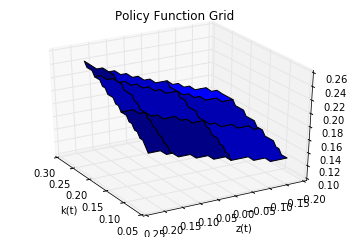

In [18]:
# create meshgrid
zmesh, kmesh = np.meshgrid(zgrid, kgrid)

# plot grid approximation of policy function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kmesh, zmesh, PF)
ax.view_init(30, 150)
plt.title('Policy Function Grid')
plt.xlabel('k(t)')
plt.ylabel('z(t)')
plt.show()

Calculate the values using the closed-form policy function and plot this.

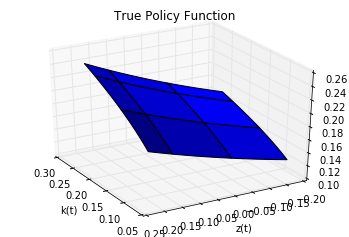

In [19]:
# caclulate and plot closed form solution for policy function
TruePF = np.zeros((knpts, znpts))
for i in range (0, knpts):
    for j in range(0, znpts):
        TruePF[i, j] = alpha*beta*kgrid[i]**alpha*np.exp(zgrid[j])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kmesh, zmesh, TruePF)
ax.view_init(30, 150)
plt.title('True Policy Function')
plt.xlabel('k(t)')
plt.ylabel('z(t)')
plt.show()